In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras
import utils 
from importlib import reload 
reload(utils)

<module 'utils' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils.py'>

### Analytic Solution of Black-Scholes model

In [2]:
N=100 # time disrectization    
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0
K = strike
sigma=0.2 # volatility in Black Scholes    
option_type = 'eurocall'
# option_type = 'eurodigitalcall'

utils.BlackScholes(T, S0, strike, sigma, option_type)

(0.07965567455405798, 0.539827837277029)

### Build neural networks at each trading time

In [3]:
m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers
Networks = utils.build_network(m, n , d, N)
Network0 = keras.layers.Dense(m, use_bias=False)
print('neural network at time 0.36 is: ')
# Networks[36].summary()

neural network at time 0.36 is: 


### Build the deep hedging dynamic 

In [4]:
price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
hedge = tf.zeros_like(price[:,0,:])  # X_{0} = 0; (batch, m)
premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
for j in range(N):
    strategy = Networks[j](price[:,j,:])  # H_{t} = nn(S_{t}); (batch, m)
    hedge = hedge + strategy * price_difference[:,j,:]   # dX_{t} = H_{t}dS_{t}; (batch, m)
outputs = premium + hedge # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
model_hedge = keras.Model(inputs=price, outputs=outputs)

In [5]:
if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

### Generate price paths of Black-Scholes model
$$
S_{t} = S_{0}e^{\sigma W_{t} - \frac{\sigma^{2}}{2}t}
$$

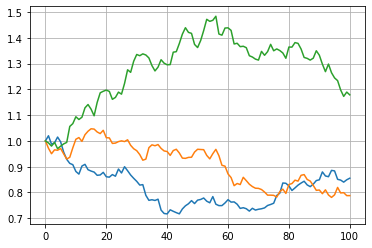

In [6]:
Ktrain = 10**5
price_path = utils.stimulate_GBM(m,Ktrain,N,T,sigma,S0)
payoff = payoff_function(price_path[:,-1,:]) 
plt.plot(price_path[:3,:,0].T)
plt.grid()
plt.show()

In [7]:
xtrain = price_path  # input be price_path
ytrain = payoff  # output be payoff
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
model_hedge.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=1000) # train the model 
hedge_output = model_hedge.predict(xtrain) # compute the output (deep replicate payoff) with trained model 

Epoch 1/10
100/100 [==============================] - 3s 28ms/step - loss: 0.2149
Epoch 2/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0039
Epoch 3/10
100/100 [==============================] - 3s 27ms/step - loss: 4.9938e-04
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 1.9181e-04
Epoch 5/10
100/100 [==============================] - 3s 26ms/step - loss: 1.2614e-04
Epoch 6/10
100/100 [==============================] - 3s 28ms/step - loss: 1.0250e-04
Epoch 7/10
100/100 [==============================] - 3s 27ms/step - loss: 9.2335e-05
Epoch 8/10
100/100 [==============================] - 3s 28ms/step - loss: 8.6321e-05
Epoch 9/10
100/100 [==============================] - 3s 26ms/step - loss: 8.2765e-05
Epoch 10/10
100/100 [==============================] - 3s 27ms/step - loss: 8.1830e-05


### Compared with delta hedging 

In [8]:
delta_output = utils.delta_hedge(price_path,T,strike,sigma,option_type)

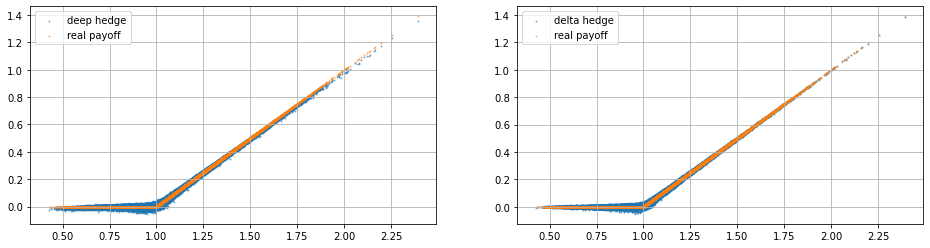

In [9]:
f,p = plt.subplots(1,2, figsize = [16,4])
p[0].scatter(price_path[:,-1,0], hedge_output[:,0], s = 1, alpha = 0.5, label = 'deep hedge')   # deep replicate payoff 
p[1].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
for i in range(2):
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].legend()
    p[i].grid()

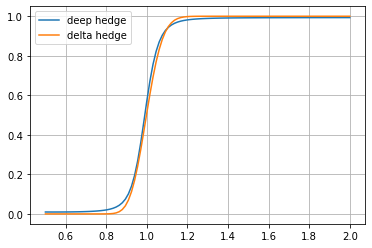

In [16]:
n = 90  # look at time 0.9
pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

he = Networks[n](pr) # the stategy network 
plt.plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

_,delta = utils.BlackScholes(T - n/N, pr, strike, sigma, option_type)
plt.plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy

plt.legend()
plt.grid()
plt.show()

In [11]:
print(f"deep hedge: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
helper,_ = utils.BlackScholes(T, S0, strike, sigma, option_type)
print(f"delta hedge: {helper:{1}.{4}}")           # premium of delta hedge (truncted printing)

deep hedge: 0.07956
delta hedge: 0.07966


### Generate Heston paths

The price of the asset $S_t$ is determined by a stochastic process:

<center> $dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}$ </center>

The instantaneous variance $\nu_t$ is a CIR process:

<center> $d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}$ </center>

Feller condition

$$
2\kappa \theta >\xi ^{2}
$$


In [12]:
# Ktrain = 10**5
# ## Parameters
# corr = -0.3     # correlation between the two process
# kappa = 0.9     # kappa: mean reversion rate
# theta = 0.2     # theta: long-term volatility
# xi = 0.2        # xi: volatility of volatility
# ## Initialization - could have other values
# S0_tiled = 1 * np.ones((Ktrain,m))
# v0 = theta * np.ones((Ktrain,m))
# price_path, vol_path = utils.stimulate_Heston(m,Ktrain,N,T,corr,kappa,theta,xi,S0_tiled,v0)
# payoff = payoff_function(price_path[:,-1,:]) 
# plt.plot(price_path[:3,:,0].T)
# plt.grid()
# plt.show()